In [288]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

import geopandas as gpd
from geoutils import utils

import rasterio as rs
from rasterio import mask
import scipy.ndimage
import xarray as xr
from PIL import Image

import os,sys

In [258]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [259]:
%pylab inline
plt.style.use("bmh")

Populating the interactive namespace from numpy and matplotlib


In [260]:
plt.rcParams.update({
    'font.size': 14,
    'font.family': 'Lato',
    'text.color': 'black',
    'axes.facecolor':'white',
    'figure.facecolor':'white',
    'axes.titlesize': 12,
    # 'axes.labelsize': 8
    # 'xtick.labelsize': 10,
    # 'ytick.labelsize': 10
})

# Reading image
When the image is big (high resolution) enough to plot for the big area, the best solution would do downsampling to avoid any memory crash

In [261]:
rast = rs.open('../../../concat_img_merged_2000.tif')
downscale_factor = 5
img = rast.read([3,2,1],out_shape=(
                3,
                int(rast.height / downscale_factor),
                int(rast.width / downscale_factor)
                                    ),
            resampling=0
            )

# Steps to prepare the image to plot
* Move axis to match the `imshow` requirment
* Normlize the data between 0-1 (Landsat data are scaled between 0-40,000)
* To make it brighter, it is recommended to multiply the image by a nummber
* Range the data between 0-1 in case there are values bigger than 1
* If the image includes `NAN` to avoid black PXs, it is possible to replace them with 1

In [262]:
img = np.clip(np.moveaxis(img,0,2)*5/40000,0,1)

In [263]:
# The bounding box in data coordinates that the image will fill. The image is stretched individually along x and y to fill the box.
minx, miny, maxx, maxy = rast.bounds

In [264]:
minx, miny, maxx, maxy

(4005195.2978272187, 2431955.6362599344, 4400055.297827219, 2773295.6362599344)

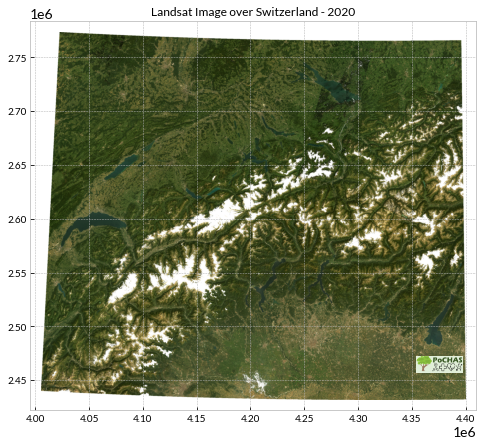

In [265]:
fig = plt.figure(1,figsize=(8,8))
plt.imshow(np.where(img==0,1,img),extent=(minx, maxx, miny, maxy))
plt.title('Landsat Image over Switzerland - 2020' )
plt.tick_params(labelsize=10,labelbottom=True,labelleft=True)
plt.xlim(minx-10e3, maxx+10e3)
plt.ylim(miny-10e3, maxy+10e3)


logo = Image.open('../../../Logo_design.png')
tmp_ax = fig.add_axes([0.795, 0.18, 0.08, 0.08], anchor='NE', zorder=+1)
tmp_ax.imshow(logo, alpha=1)
tmp_ax.axis('off')
plt.show()

# Mask the AOI and plot it
* One of the chaleenages after clipping the raster is its high resolution which makes calculation tough. `scipy.ndimage.zoom` can be used for downsampling\
https://www.geeksforgeeks.org/how-to-resample-numpy-array-representing-an-image/

In [266]:
def clip_area_of_interest(geom):
    rast = rs.open('../../../concat_img_merged_2000.tif')
    out_image, out_transform = mask.mask(rast, geom, crop=True,nodata=-1)
    return out_image

In [267]:
aoi = gpd.read_file('../../../CHE_3035.geojson')
img_ = clip_area_of_interest(aoi['geometry'])
img_ = scipy.ndimage.zoom(img_, (1,0.20,0.20), order = 3)
img_ = np.clip(np.moveaxis(img_[[2,1,0],:,:],0,2)*5/40000,0,1)

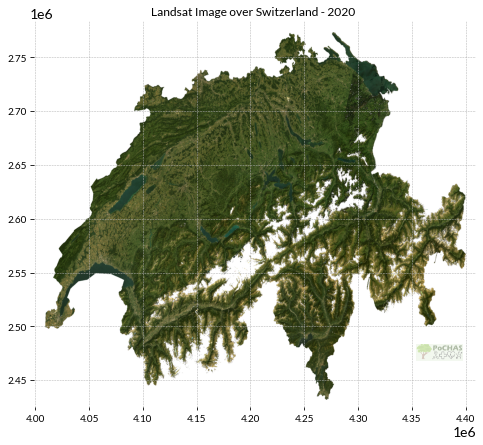

In [268]:
fig = plt.figure(1,figsize=(8,8))
plt.imshow(img_,extent=(minx, maxx, miny, maxy))
plt.title('Landsat Image over Switzerland - 2020')
plt.xlim(minx-10e3, maxx+10e3)
plt.ylim(miny-10e3, maxy+10e3)
plt.tick_params(labelsize=10,labelbottom=True,labelleft=True)


logo = Image.open('../../../Logo_design.png')
tmp_ax = fig.add_axes([0.795, 0.20, 0.08, 0.08], anchor='NE', zorder=+1)
tmp_ax.imshow(logo, alpha=.40)
tmp_ax.axis('off')

sns.despine(left=True, bottom=True);
plt.show()

# Plotting the vector on the image

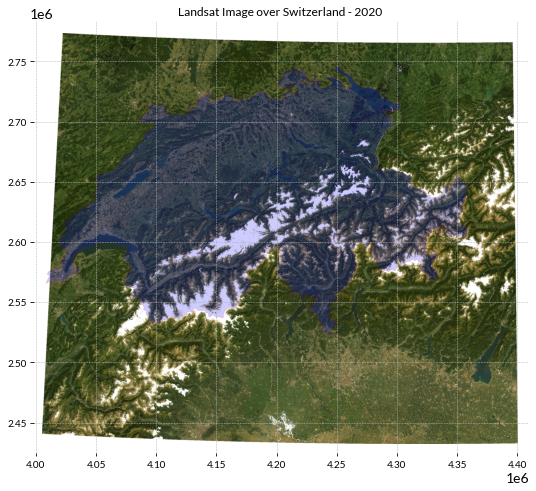

In [269]:
fig = plt.figure(1,figsize=(12,8))
plt.imshow(np.where(img==0,1,img),extent=(minx, maxx, miny, maxy))
aoi.plot(ax=plt.gca(),alpha=0.2,edgecolor='red')

plt.xlim(minx-10e3, maxx+10e3)
plt.ylim(miny-10e3, maxy+10e3)
plt.tick_params(labelsize=10,labelbottom=True,labelleft=True)

plt.title('Landsat Image over Switzerland - 2020')
sns.despine(left=True, bottom=True);
plt.show()

# Multipanel Plotting

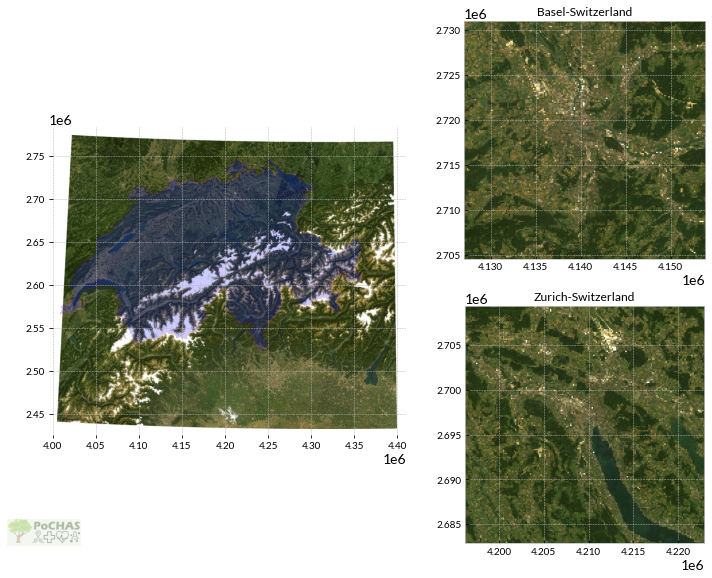

In [270]:
fig = plt.figure(1, figsize=([12.8, 9.6]))
gs = plt.GridSpec(4,4, wspace=0, hspace=0.50)

# Panel 01
xtr_subsplot= fig.add_subplot(gs[0:4,0:2])
plt.imshow(np.where(img==0,1,img),extent=(minx, maxx, miny, maxy))
aoi.plot(ax=plt.gca(),alpha=0.2,edgecolor='red')

plt.xlim(minx-10e3, maxx+10e3)
plt.ylim(miny-10e3, maxy+10e3)
plt.tick_params(labelsize=10,labelbottom=True,labelleft=True)
sns.despine(left=True, bottom=True);

# Panel 02
xtr_subsplot = fig.add_subplot(gs[0:2,2:4])
plt.imshow(np.where(img==0,1,img),extent=(minx, maxx, miny, maxy))

plt.xlim(4137003.0508-10e3, 4143839.7353+10e3)
plt.ylim(2714544.3778-10e3, 2720918.2099+10e3)
plt.tick_params(labelsize=10,labelbottom=True,labelleft=True)

plt.title('Basel-Switzerland')

# Panel 03
xtr_subsplot = fig.add_subplot(gs[2:4,2:4])
plt.imshow(np.where(img==0,1,img),extent=(minx, maxx, miny, maxy))

plt.xlim(4206147.8472-10e3, 4212918.0645+10e3)
plt.ylim(2692843.3169-10e3, 2699361.9776+10e3)
plt.tick_params(labelsize=10,labelbottom=True,labelleft=True)

plt.title('Zurich-Switzerland')

logo = Image.open('../../../Logo_design.png')
tmp_ax = fig.add_axes([0.08, 0.08, 0.08, 0.08], anchor='NW', zorder=+1)
tmp_ax.imshow(logo, alpha=.40)
tmp_ax.axis('off')
      
plt.show()


## TODO:
* Create a GIF using NDVI
* Multipanel with GIF

In [271]:
!ls ../../..

anaconda3		    LULC_modeling_s2
cat_data		    ndvi_timeSeries_weekly_filtered.nc
CHE_3035.geojson	    new_data.parquet
concat_img_merged_2000.tif  points.csv
dask-worker-space	    SQL_GDAL_Commnds
data			    test_catvnoncat.h5
data.zip		    test.py
generic_plot01.png	    test.tif
generic_plot.png	    train_catvnoncat.h5
images			    trial.ipynb
Logo_design.png


In [272]:
ds = xr.open_dataset('../../../ndvi_timeSeries_weekly_filtered.nc')

In [273]:
ds

<xarray.Dataset>
Dimensions:  (time: 992, y: 260, x: 389)
Coordinates:
  * x        (x) float64 3.989e+06 3.99e+06 3.991e+06 ... 4.376e+06 4.377e+06
  * y        (y) float64 2.78e+06 2.779e+06 2.778e+06 ... 2.522e+06 2.521e+06
  * time     (time) datetime64[ns] 2002-01-03 2002-01-10 ... 2020-12-31
Data variables:
    NDVI     (time, y, x) int16 ...
Attributes:
    description:  NDVI with resolution 1km in epsg:3035 coordinate system

In [334]:
ds_2020 = ds.sel(time=slice("2020-01-01","2020-12-31"))

In [275]:
ndvi = ds_2020.NDVI.values
time = ds_2020.time.values
ndvi.shape, time.shape

((53, 260, 389), (53,))

In [276]:
maxx = ds_2020.x.values.max()
minx = ds_2020.x.values.min()
miny = ds_2020.y.values.min()
maxy = ds_2020.y.values.max()

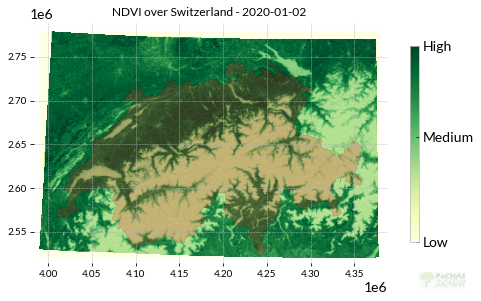

In [277]:
fig = plt.figure(1,figsize=(8,8))
map = plt.imshow(ndvi[1,:,:],extent=(minx, maxx, miny, maxy),vmin=-5000, vmax=8000,cmap=plt.cm.YlGn)

cbar = plt.colorbar(map,shrink=0.45,ticks=[-5000,2000,8000])
cbar.set_ticklabels(['Low', 'Medium', 'High'])

plt.title(f'NDVI over Switzerland - {str(time[0])[:10]}')
plt.tick_params(labelsize=10,labelbottom=True,labelleft=True)
plt.xlim(minx-10e3, maxx+10e3)
plt.ylim(miny-10e3, maxy+10e3)

aoi.plot(ax=plt.gca(),alpha=0.2,edgecolor='black',color='red')

sns.despine(left=True, bottom=True);

logo = Image.open('../../../Logo_design.png')
tmp_ax = fig.add_axes([0.80, 0.2, 0.08, 0.08], anchor='NE', zorder=+1)
tmp_ax.imshow(logo, alpha=0.2)
tmp_ax.axis('off')
plt.show()

# TIP
* To use `sel` function in `Xarray`, do not forget to determine *y* from `max` to `min` while *x* should be from `min` to `max`

In [336]:
ds_2020_patch = ds.sel(time=slice("2020-01-01","2020-12-31"),x=slice(4164974.1407-10e3,4178608.1981+10e3),y=slice(2653655.2519+10e3,2643999.4355-10e3))
ds_2018_CH = ds.sel(time=slice("2018-01-01","2020-12-31"))

In [337]:
maxx_ = ds_2018_CH.x.values.max()
minx_ = ds_2018_CH.x.values.min()
miny_ = ds_2018_CH.y.values.min()
maxy_ = ds_2018_CH.y.values.max()

In [345]:
ndvi_CH = (ds_2018_CH.NDVI.values)*0.0001 #modis NDVI data scale factor
time_ = ds_2018_CH.time.values
ndvi_CH.shape, time_.shape

((157, 260, 389), (157,))

In [387]:
for i in range(0,157):
    fig = plt.figure(1, figsize=([8, 8]))
    gs = plt.GridSpec(6,4, wspace=0.25, hspace=0.25)

    # Panel 01
    xtr_subsplot= fig.add_subplot(gs[0:4,0:4])

    map = plt.imshow(np.clip(ndvi_CH[i,:,:],-2,1),extent=(minx, maxx, miny, maxy),vmin=-1, vmax=1,cmap=plt.cm.YlGn)
    cbar = plt.colorbar(map,shrink=0.8,ticks=[-1,0,1])
    cbar.set_ticklabels(['Low', 'Medium', 'High'])

    plt.title(f'MODIS NDVI, Switzerland - {str(time_[i])[:10]}' )
    plt.tick_params(labelsize=10,labelbottom=True,labelleft=True,left=False)

    aoi.plot(ax=plt.gca(),alpha=0.2,edgecolor='red',linewidth=5)

    # Panel 02
    xtr_subsplot= fig.add_subplot(gs[4:6,0:3])
    sns.kdeplot(np.clip(ndvi_CH[i,:,:],-2,1).flatten(),color="#509666")
    plt.tick_params(labelsize=8,labelbottom=True,labelleft=True,width=0)
    plt.ylabel('')
    plt.xlim([-1,1.1])
    plt.ylim([0,3.7])


    logo = Image.open('../../../Logo_design.png')
    tmp_ax = fig.add_axes([0.80, 0.05, 0.08, 0.08], anchor='NE', zorder=+1)
    tmp_ax.imshow(logo, alpha=0.2)
    tmp_ax.axis('off')

    author_ax = fig.add_axes([0.80, 0.05, 0.08, 0.08], anchor='NE', zorder=+1)
    author_ax.text(0,0, 'Author: BVSh', fontsize=8)
    author_ax.axis('off')

    sns.despine(left=True, bottom=True);

    plt.savefig(f'../../../images/ndvi_{str(time_[i])[:10]}.png', dpi=300,bbox_inches="tight")
    # plt.show()
    plt.close()


In [388]:
fp_out = "../../../ndvi_2018_2020.gif"

# https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
img, *imgs = [Image.open(f) for f in sorted(utils.list_files_with_absolute_paths('../../../images/',endswith='png'))]
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=200, loop=0)